In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Читаем и обрабатываем данные

In [3]:
# Читаем файл, нейминг возьмем со второй строки
df = pd.read_csv('ТЗ аналитик данных - Тестовые заемщики.csv', header=[1])
df.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,Unnamed: 6,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3 170 000 ₽,7,"5,30%",211 051 ₽,862 850 ₽,"1,50%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500 000 ₽,17,"6,50%",39 518 ₽,289 518 ₽,"10,00%",NaN,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11 600 897 ₽,9,"4,50%",537 680 ₽,9 567 386 ₽,"1,50%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5 250 000 ₽,13,"4,50%",233 022 ₽,2 858 022 ₽,"1,50%",NaN,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3 000 000 ₽,8,"3,75%",216 485 ₽,0 ₽,"0,00%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Заведем таблицу с признаками
features = df.drop(['Loan issued', 'Рейтинг', 'Comission, %', 'Earned interest', 'Unpaid,  full amount', 'EL', 'Unnamed: 6'], axis=1)
features.head()

,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,Не знает объем выручки,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Приведем столбец из типа object к int
df['Loan issued'] = df['Loan issued'].map(lambda x: x.lstrip(' ').rstrip('₽'))
df['Loan issued'] = df['Loan issued'].str.replace(' ', '').astype(int)

df['Unpaid,  full amount'] = df['Unpaid,  full amount'].map(lambda x: x.lstrip(' ').rstrip('₽'))
df['Unpaid,  full amount'] = df['Unpaid,  full amount'].str.replace(' ', '').astype(int)

df['Earned interest'] = df['Earned interest'].map(lambda x: x.lstrip(' ').rstrip('₽'))
df['Earned interest'] = df['Earned interest'].str.replace(' ', '').astype(int)
df.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,Unnamed: 6,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3170000,7,"5,30%",211051,862850,"1,50%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500000,17,"6,50%",39518,289518,"10,00%",NaN,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11600897,9,"4,50%",537680,9567386,"1,50%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5250000,13,"4,50%",233022,2858022,"1,50%",NaN,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3000000,8,"3,75%",216485,0,"0,00%",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df["Comission, %"] = df['Comission, %'].str.replace('%', '')
df["Comission, %"] = df['Comission, %'].str.replace(',', '.').astype(float)

df["EL"] = df['EL'].str.replace('%', '')
df["EL"] = df['EL'].str.replace(',', '.').astype(float)

df["EL"] = np.dot(df["EL"], 0.01)

In [7]:
#Обработка данных

#Уберем все столбцы с более 90 процентов пропущенных значений
df.dropna(thresh=int(df.shape[1] * .95), axis=1, inplace = True)

# Визуализируем данные

In [8]:
#Посмотрим на данные
sumtbl = df.pivot_table(index=['Comission, %'],  values=["Loan issued"], columns=['Рейтинг'], aggfunc='mean')
sumtbl.head(15)

Loan issued                                                       \
Рейтинг               1   2   3           4          5          6          7    
Comission, %                                                                    
2.00                 NaN NaN NaN         NaN        NaN        NaN        NaN   
2.13                 NaN NaN NaN         NaN        NaN        NaN        NaN   
2.15                 NaN NaN NaN         NaN        NaN        NaN        NaN   
2.24                 NaN NaN NaN         NaN        NaN        NaN        NaN   
2.25                 NaN NaN NaN         NaN        NaN        NaN        NaN   
2.50                 NaN NaN NaN         NaN        NaN  3000000.0        NaN   
2.65                 NaN NaN NaN         NaN        NaN        NaN        NaN   
2.72                 NaN NaN NaN         NaN        NaN        NaN        NaN   
2.83                 NaN NaN NaN  13570000.0        NaN        NaN        NaN   
2.90                 NaN NaN NaN         NaN        NaN        NaN  4000000.0   
2.91                 NaN NaN NaN         NaN  6200000.0        NaN        NaN   
2.95                 NaN NaN NaN         NaN        NaN        NaN        NaN   
3.00                 NaN NaN NaN   6000000.0  4000000.0  4000000.0   500000.0   
3.02                 NaN NaN NaN         NaN        NaN        NaN        NaN   
3.12                 NaN NaN NaN   6500000.0        NaN        NaN        NaN   

                                                                              \
Рейтинг              8          9   10          11         12         13  14   
Comission, %                                                                   
2.00                NaN  2750000.0 NaN         NaN        NaN  1836735.0 NaN   
2.13                NaN        NaN NaN         NaN  3000000.0        NaN NaN   
2.15          8700000.0        NaN NaN         NaN        NaN        NaN NaN   
2.24                NaN  8640000.0 NaN         NaN        NaN        NaN NaN   
2.25                NaN        NaN NaN         NaN   800000.0        NaN NaN   
2.50          1648213.5        NaN NaN         NaN        NaN        NaN NaN   
2.65                NaN        NaN NaN  11200000.0        NaN        NaN NaN   
2.72                NaN  7000000.0 NaN         NaN        NaN        NaN NaN   
2.83                NaN        NaN NaN         NaN        NaN        NaN NaN   
2.90                NaN        NaN NaN         NaN        NaN        NaN NaN   
2.91                NaN        NaN NaN         NaN        NaN        NaN NaN   
2.95                NaN        NaN NaN  10000000.0        NaN        NaN NaN   
3.00                NaN  3000000.0 NaN         NaN  2250000.0  3018155.0 NaN   
3.02                NaN        NaN NaN   2500000.0        NaN        NaN NaN   
3.12                NaN        NaN NaN         NaN        NaN        NaN NaN   

                                           
Рейтинг       15         16        17  18  
Comission, %                               
2.00         NaN        NaN       NaN NaN  
2.13         NaN        NaN       NaN NaN  
2.15         NaN        NaN       NaN NaN  
2.24         NaN        NaN       NaN NaN  
2.25         NaN        NaN       NaN NaN  
2.50         NaN        NaN       NaN NaN  
2.65         NaN        NaN       NaN NaN  
2.72         NaN        NaN       NaN NaN  
2.83         NaN        NaN       NaN NaN  
2.90         NaN        NaN       NaN NaN  
2.91         NaN        NaN       NaN NaN  
2.95         NaN        NaN       NaN NaN  
3.00         NaN  3000000.0  600000.0 NaN  
3.02         NaN        NaN       NaN NaN  
3.12         NaN        NaN       NaN NaN

(array([113.,  72.,  84.,  44.,  61.,  36.,  16.,  36.,  21.,   7.,   7.,
          4.,   3.,   7.,   1.,   6.,   1.,   4.,   3.,   1.,   1.,   2.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  500000. ,  1114912.9,  1729825.8,  2344738.7,  2959651.6,
         3574564.5,  4189477.4,  4804390.3,  5419303.2,  6034216.1,
         6649129. ,  7264041.9,  7878954.8,  8493867.7,  9108780.6,
         9723693.5, 10338606.4, 10953519.3, 11568432.2, 12183345.1,
        12798258. , 13413170.9, 14028083.8, 14642996.7, 15257909.6,
        15872822.5, 16487735.4, 17102648.3, 17717561.2, 18332474.1,
        18947387. ]),
 <BarContainer object of 30 artists>)

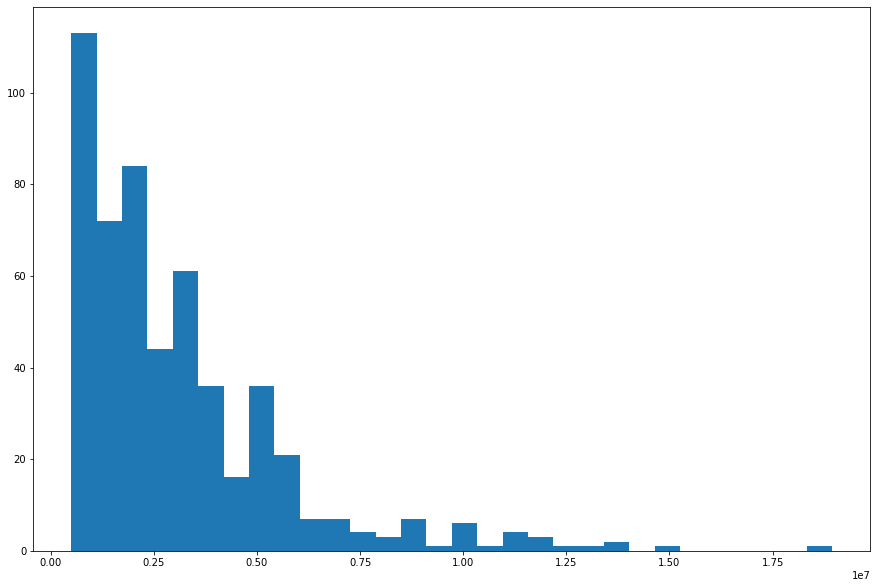

In [9]:
plt.figure(figsize=(15, 10))
plt.hist(df["Loan issued"], bins=30)

(array([75., 70., 67., 65., 44., 44., 21., 22., 33., 22., 10., 10., 12.,
         8.,  7.,  6.,  6.,  3.,  1.,  1.,  1.,  3.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([     0. ,  24667.7,  49335.4,  74003.1,  98670.8, 123338.5,
        148006.2, 172673.9, 197341.6, 222009.3, 246677. , 271344.7,
        296012.4, 320680.1, 345347.8, 370015.5, 394683.2, 419350.9,
        444018.6, 468686.3, 493354. , 518021.7, 542689.4, 567357.1,
        592024.8, 616692.5, 641360.2, 666027.9, 690695.6, 715363.3,
        740031. ]),
 <BarContainer object of 30 artists>)

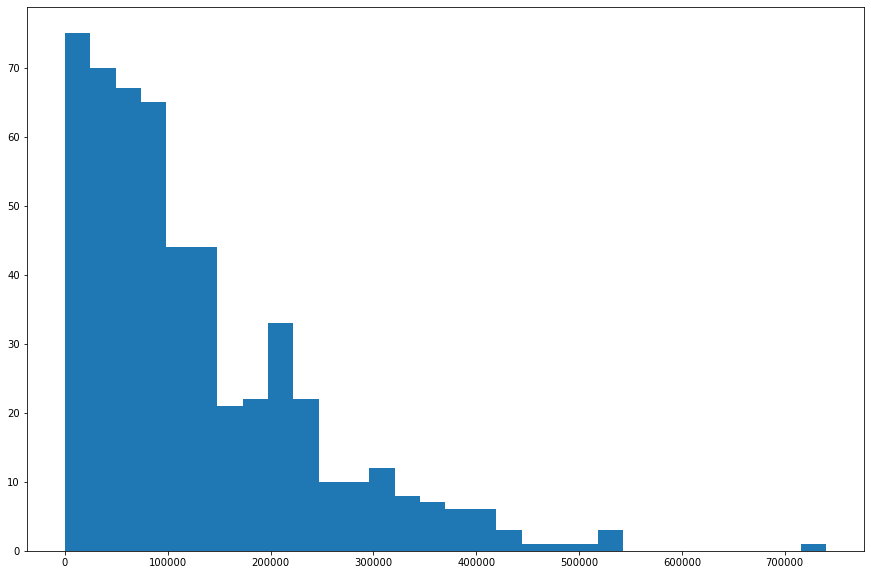

In [10]:
plt.figure(figsize=(15, 10))
plt.hist(df["Earned interest"], bins=30)

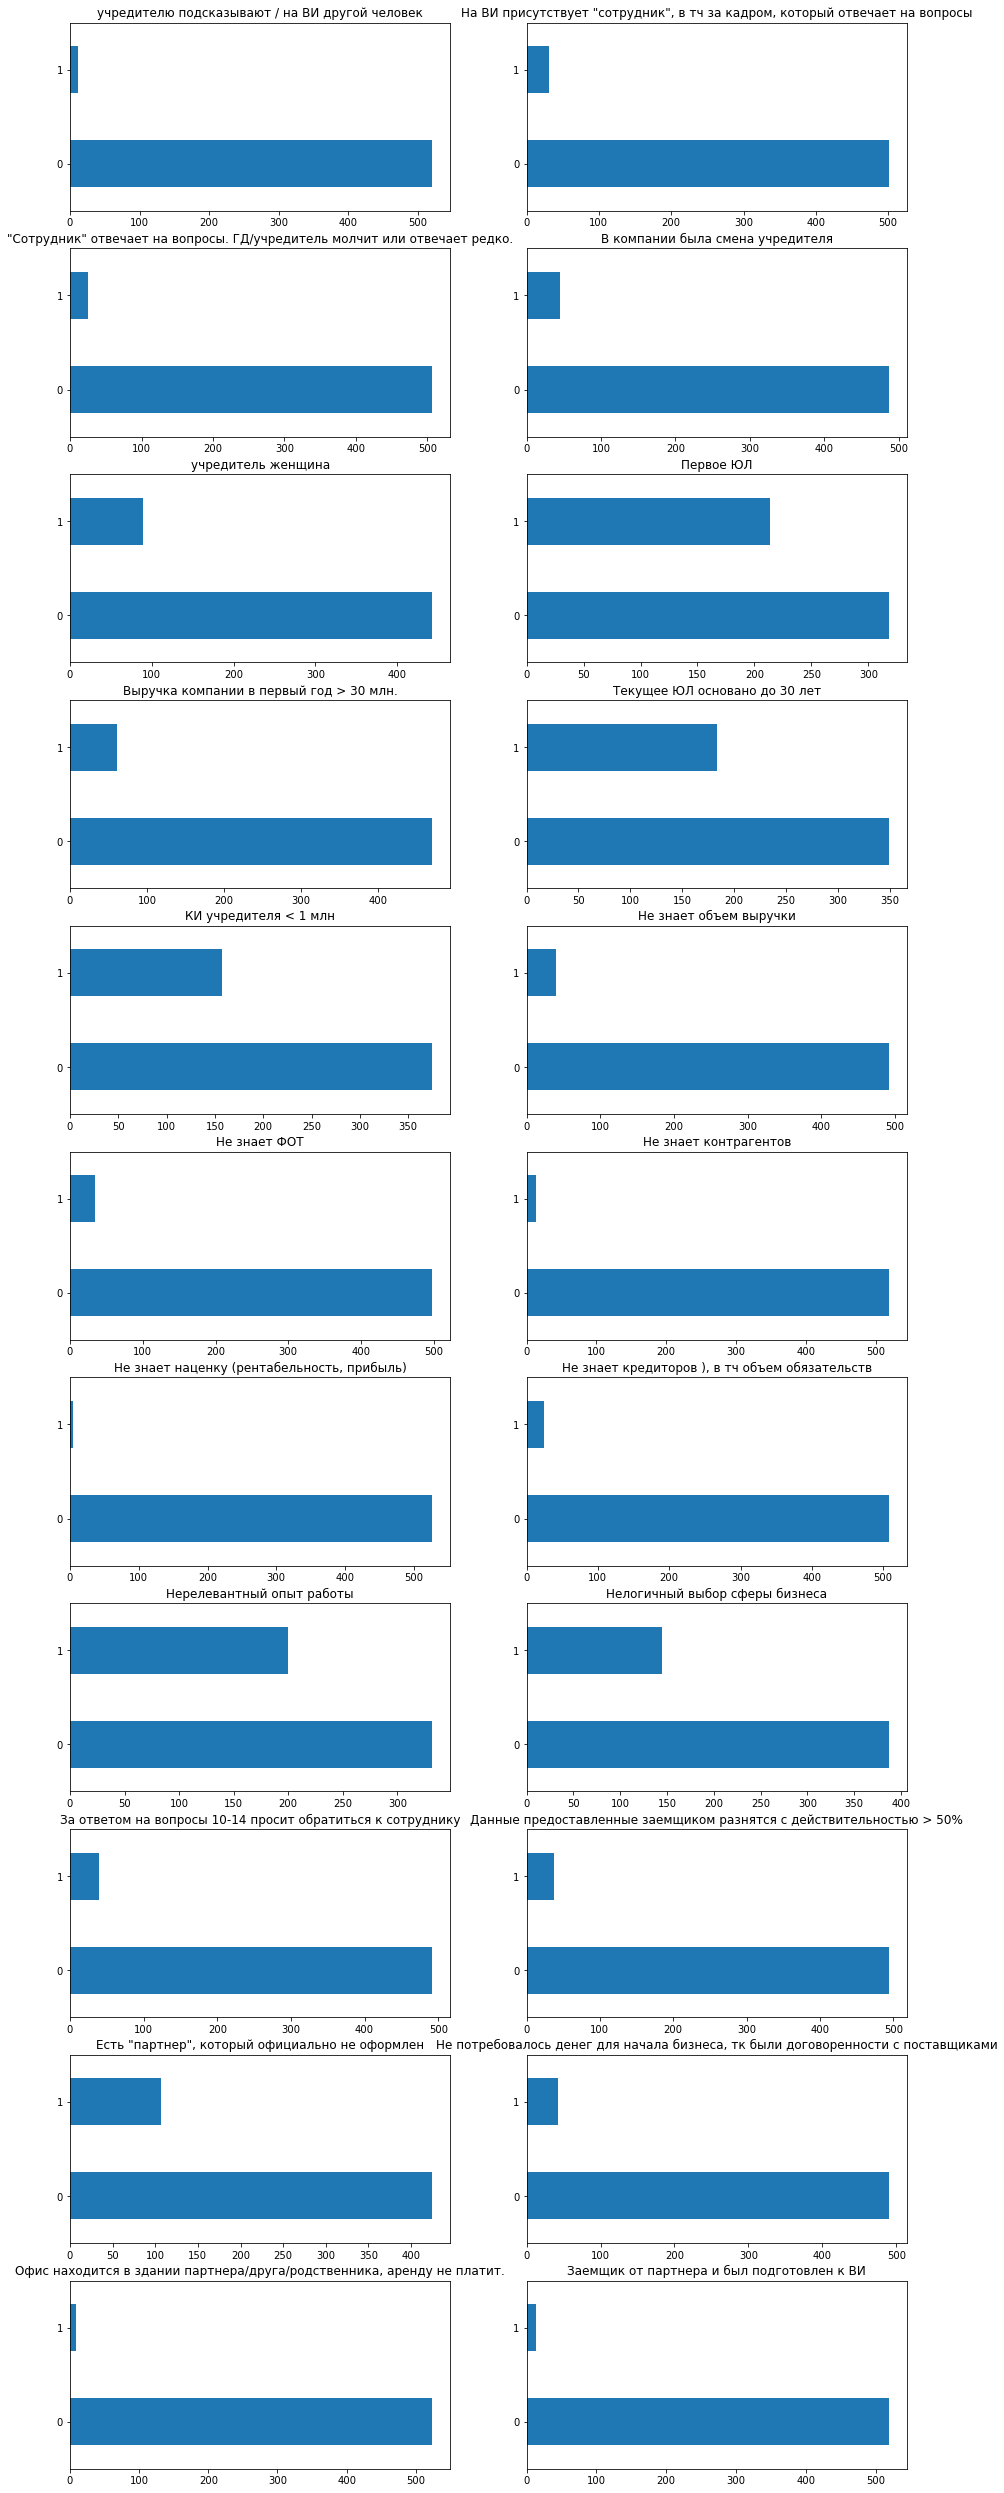

In [11]:
#Посмотрим на распределение фичей
plt.figure(figsize=(15, 45))

k = 0
for i in features:
    k += 1
    plt.subplot(11, 2, k)
    features[i].value_counts().plot(kind="barh")
    plt.title(i)

plt.show()

Выбросов и аномалий не наблюдается

In [12]:
# Посчитаем основные параметры:
EL = np.dot(df["EL"], 0.01)
Loss = df["Unpaid,  full amount"] * EL #df.loc[:,'quantity'] * EL
InvestorProfit = df["Earned interest"] - Loss
Profit = InvestorProfit + (df["Comission, %"] * 0.01) * df["Loan issued"]
Profit_percent = Profit / df["Loan issued"] * 100

In [13]:
Profit_percent.head(10)

0    11.953677
1    14.345696
2     9.122443
3     8.930349
4    10.966167
5     9.338674
6    13.259888
7     8.731110
8     9.209351
9    11.437283
dtype: float64

In [14]:
print("Среднее значение % экономической прибыли по выборке:")
Profit_percent.mean()

Среднее значение % экономической прибыли по выборке:


9.843471069635658

Посмотрим на распределение % экономической прибыли

(array([ 5., 12.,  8., 20., 25., 37., 35., 34., 41., 52., 48., 30., 32.,
        25., 25., 25., 14., 12.,  5.,  7., 16.,  6.,  3.,  4.,  5.,  1.,
         0.,  2.,  0.,  3.]),
 array([ 3.33434535,  3.94722934,  4.56011332,  5.1729973 ,  5.78588128,
         6.39876526,  7.01164925,  7.62453323,  8.23741721,  8.85030119,
         9.46318517, 10.07606916, 10.68895314, 11.30183712, 11.9147211 ,
        12.52760508, 13.14048907, 13.75337305, 14.36625703, 14.97914101,
        15.59202499, 16.20490897, 16.81779296, 17.43067694, 18.04356092,
        18.6564449 , 19.26932888, 19.88221287, 20.49509685, 21.10798083,
        21.72086481]),
 <BarContainer object of 30 artists>)

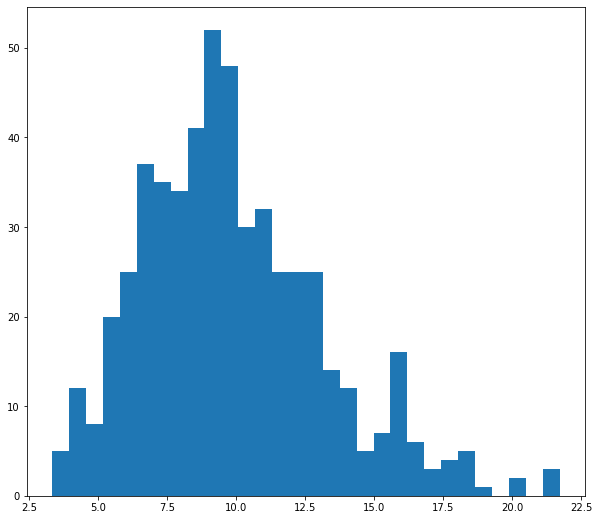

In [15]:
plt.figure(figsize=(10, 9))
plt.hist(Profit_percent, bins=30)

# Обучение модели XGBoost

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, Profit_percent, test_size=0.3, random_state=1337)

In [17]:
# Уберем <[] из названий столбцов
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [18]:
xgb_r = xg.XGBRegressor(objective ='reg:linear', seed = 1337) # n_estimators = 10 objective ='reg:linear',

# Fitting the model
xgb_r.fit(X_train, y_train)

[18:46:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=1337, reg_alpha=0, ...)

In [19]:
# Predict the model
pred = xgb_r.predict(X_test)

# MAE Computation
mae = MAE(y_test, pred)
print("MAE : % f" %(mae))

MAE :  3.090221


In [20]:
Profit_percent.max()

21.720864811704526

Как мы видим, максимальное значение % экономической прибыли равно 21.7%.
Таким образом, можем прогнозировать доходность на основе факторов с погрешностью в 3%. Таким образом, для максимизации прибыли мы можем выбирать всех клиентов с доходностью большее 18.7% (Либо выбрать любой другой устраиваемый нас порог).